# Task 1: Exploratory Data Analysis - Brent Oil Prices

**Project:** Bayesian Change Point Analysis of Brent Oil Prices  
**Organization:** Birhan Energies  
**Date:** February 5, 2026

## Objective
Perform comprehensive exploratory data analysis to understand the properties of Brent oil price time series before applying Bayesian change point detection models.

### Key Questions:
1. What are the trends in Brent oil prices over time?
2. Is the price series stationary or does it require transformation?
3. What volatility patterns exist in the data?
4. How should these properties inform our modeling choices?

## 1. Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Create reports directory
REPORTS_DIR = Path('../reports/figures')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")
print(f"Figures will be saved to: {REPORTS_DIR.absolute()}")

Libraries imported successfully!
Figures will be saved to: c:\Users\Bekam\Desktop\acadamy 10\bayesian-oil-market-insights\notebooks\..\reports\figures


## 2. Load and Prepare Data

In [2]:
# Load Brent oil prices
df = pd.read_csv('../data/BrentOilPrices.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (9011, 2)

First few rows:


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
5,27-May-87,18.60
6,28-May-87,18.60
7,29-May-87,18.58
8,01-Jun-87,18.65
9,02-Jun-87,18.68


In [3]:
# Check data info
print("Dataset Information:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   str    
 1   Price   9011 non-null   float64
dtypes: float64(1), str(1)
memory usage: 140.9 KB
None

Basic Statistics:
             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


In [5]:
# Convert Date column to datetime
# Handle mixed date formats in the CSV
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Set Date as index
df.set_index('Date', inplace=True)

print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total days: {len(df)}")
print(f"\nFirst and last entries:")
print(df.head(3))
print("...")
print(df.tail(3))

Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Total days: 9011

First and last entries:
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
...
            Price
Date             
2022-11-10  94.25
2022-11-11  96.37
2022-11-14  93.59


In [6]:
# Check for missing values
missing_values = df['Price'].isna().sum()
print(f"Missing values: {missing_values}")

if missing_values > 0:
    print(f"Percentage missing: {missing_values/len(df)*100:.2f}%")
    # Forward fill missing values if any
    df['Price'].fillna(method='ffill', inplace=True)
    print("Missing values filled using forward fill method")

Missing values: 0


## 3. Visual Inspection: Raw Price Series

First, let's visualize the entire price history to identify major trends, shocks, and structural breaks.

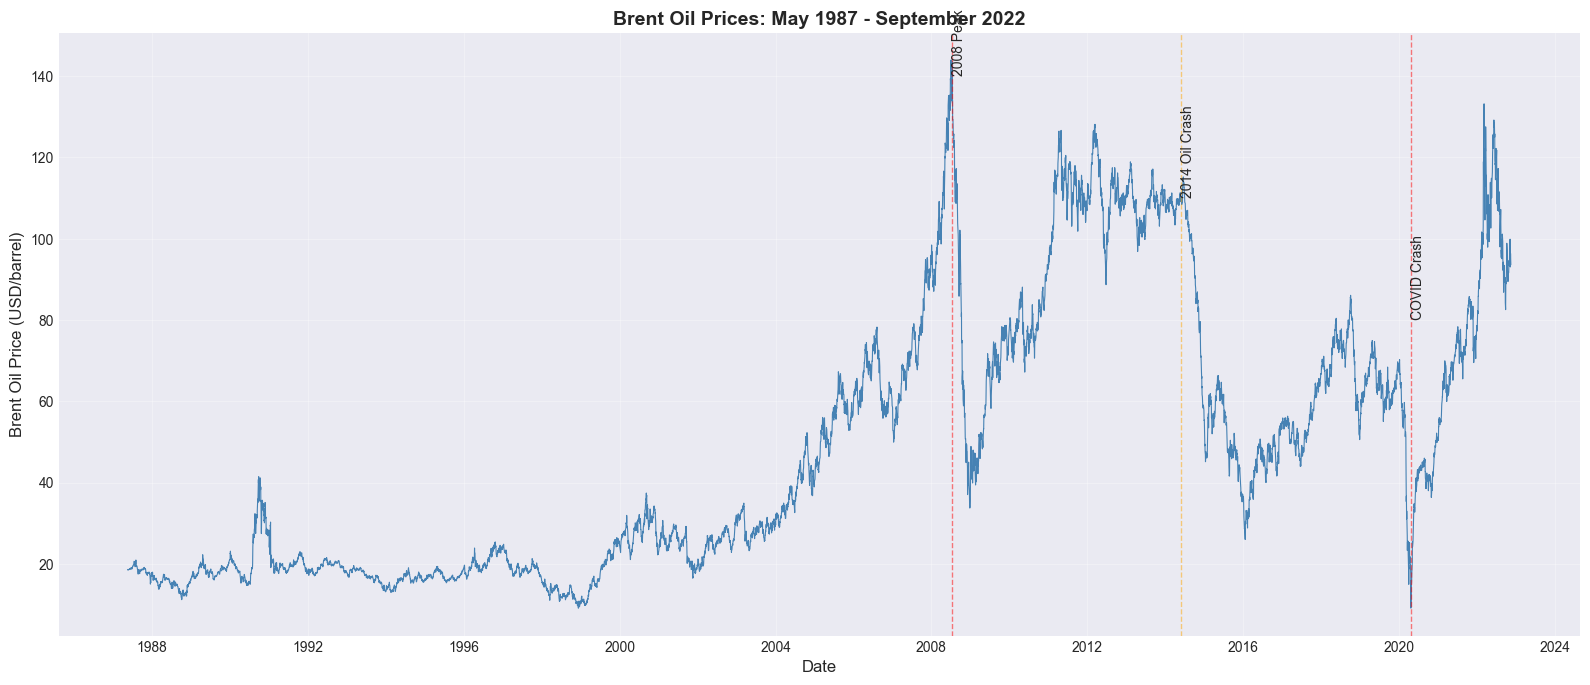


Key Observations:
- Price range: $9.10 to $143.95
- Mean price: $48.42
- Median price: $38.57
- Standard deviation: $32.86
✓ Figure saved: 01_brent_oil_prices_full_series.png


In [7]:
# Plot full time series
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(df.index, df['Price'], linewidth=0.8, color='steelblue')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Brent Oil Price (USD/barrel)', fontsize=12)
ax.set_title('Brent Oil Prices: May 1987 - September 2022', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add annotations for major visible events
ax.axvline(pd.Timestamp('2008-07-11'), color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.text(pd.Timestamp('2008-07-11'), 140, '2008 Peak', rotation=90, verticalalignment='bottom')

ax.axvline(pd.Timestamp('2020-04-20'), color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.text(pd.Timestamp('2020-04-20'), 80, 'COVID Crash', rotation=90, verticalalignment='bottom')

ax.axvline(pd.Timestamp('2014-06-01'), color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax.text(pd.Timestamp('2014-06-01'), 110, '2014 Oil Crash', rotation=90, verticalalignment='bottom')

plt.tight_layout()
plt.savefig(REPORTS_DIR / '01_brent_oil_prices_full_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Observations:")
print(f"- Price range: ${df['Price'].min():.2f} to ${df['Price'].max():.2f}")
print(f"- Mean price: ${df['Price'].mean():.2f}")
print(f"- Median price: ${df['Price'].median():.2f}")
print(f"- Standard deviation: ${df['Price'].std():.2f}")
print(f"✓ Figure saved: 01_brent_oil_prices_full_series.png")

## 4. Trend Analysis

Calculate moving averages to identify long-term trends and smoothing patterns.

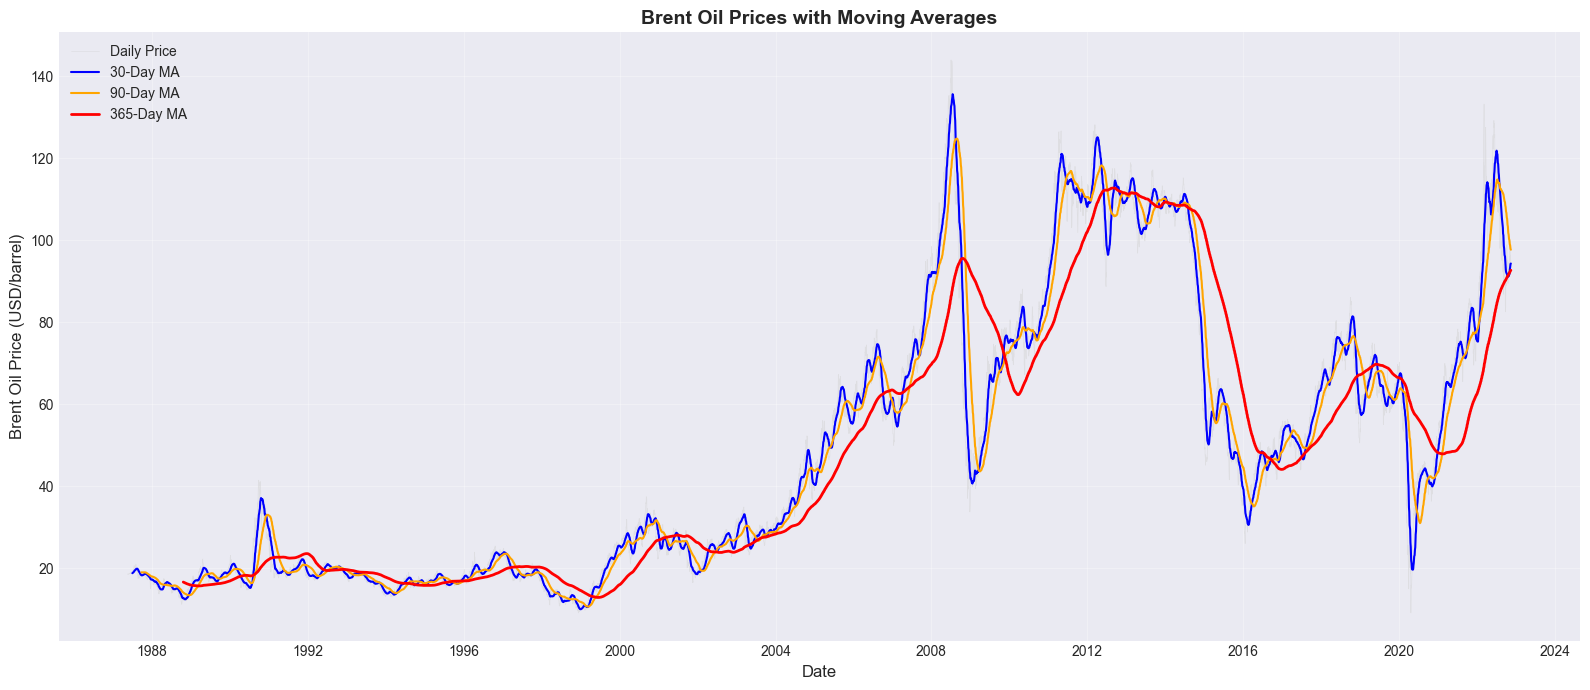

Trend Insights:
- Multiple regime shifts visible in long-term moving average
- High volatility periods clearly distinguishable
- Non-stationary behavior evident from changing mean levels
✓ Figure saved: 02_moving_averages.png


In [8]:
# Calculate moving averages
df['MA_30'] = df['Price'].rolling(window=30).mean()
df['MA_90'] = df['Price'].rolling(window=90).mean()
df['MA_365'] = df['Price'].rolling(window=365).mean()

# Plot with moving averages
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(df.index, df['Price'], linewidth=0.5, alpha=0.5, label='Daily Price', color='lightgray')
ax.plot(df.index, df['MA_30'], linewidth=1.5, label='30-Day MA', color='blue')
ax.plot(df.index, df['MA_90'], linewidth=1.5, label='90-Day MA', color='orange')
ax.plot(df.index, df['MA_365'], linewidth=2, label='365-Day MA', color='red')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Brent Oil Price (USD/barrel)', fontsize=12)
ax.set_title('Brent Oil Prices with Moving Averages', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / '02_moving_averages.png', dpi=300, bbox_inches='tight')
plt.show()

print("Trend Insights:")
print("- Multiple regime shifts visible in long-term moving average")
print("- High volatility periods clearly distinguishable")
print("- Non-stationary behavior evident from changing mean levels")
print(f"✓ Figure saved: 02_moving_averages.png")

## 5. Stationarity Testing

Use the Augmented Dickey-Fuller (ADF) test to formally test for stationarity.

In [9]:
def adf_test(series, name=''):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis (H0): Series has a unit root (non-stationary)
    Alternative Hypothesis (H1): Series is stationary
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f'\n=== ADF Test Results: {name} ===')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"\n✓ Conclusion: Reject H0 - Series is STATIONARY (p-value = {result[1]:.6f})")
    else:
        print(f"\n✗ Conclusion: Fail to reject H0 - Series is NON-STATIONARY (p-value = {result[1]:.6f})")
    
    return result

# Test raw prices
adf_result_price = adf_test(df['Price'], 'Raw Prices')


=== ADF Test Results: Raw Prices ===
ADF Statistic: -1.993856
p-value: 0.289274
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✗ Conclusion: Fail to reject H0 - Series is NON-STATIONARY (p-value = 0.289274)


## 6. Log Returns Calculation

Calculate log returns to potentially achieve stationarity:  
$$r_t = \log(P_t) - \log(P_{t-1})$$

In [10]:
# Calculate log returns
df['Log_Price'] = np.log(df['Price'])
df['Log_Returns'] = df['Log_Price'].diff()

# Also calculate simple returns for comparison
df['Simple_Returns'] = df['Price'].pct_change()

print("Log Returns Statistics:")
print(df['Log_Returns'].describe())

# Test log returns for stationarity
adf_result_returns = adf_test(df['Log_Returns'], 'Log Returns')

Log Returns Statistics:
count    9010.000000
mean        0.000179
std         0.025532
min        -0.643699
25%        -0.011154
50%         0.000402
75%         0.012127
max         0.412023
Name: Log_Returns, dtype: float64

=== ADF Test Results: Log Returns ===
ADF Statistic: -16.427113
p-value: 0.000000
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✓ Conclusion: Reject H0 - Series is STATIONARY (p-value = 0.000000)


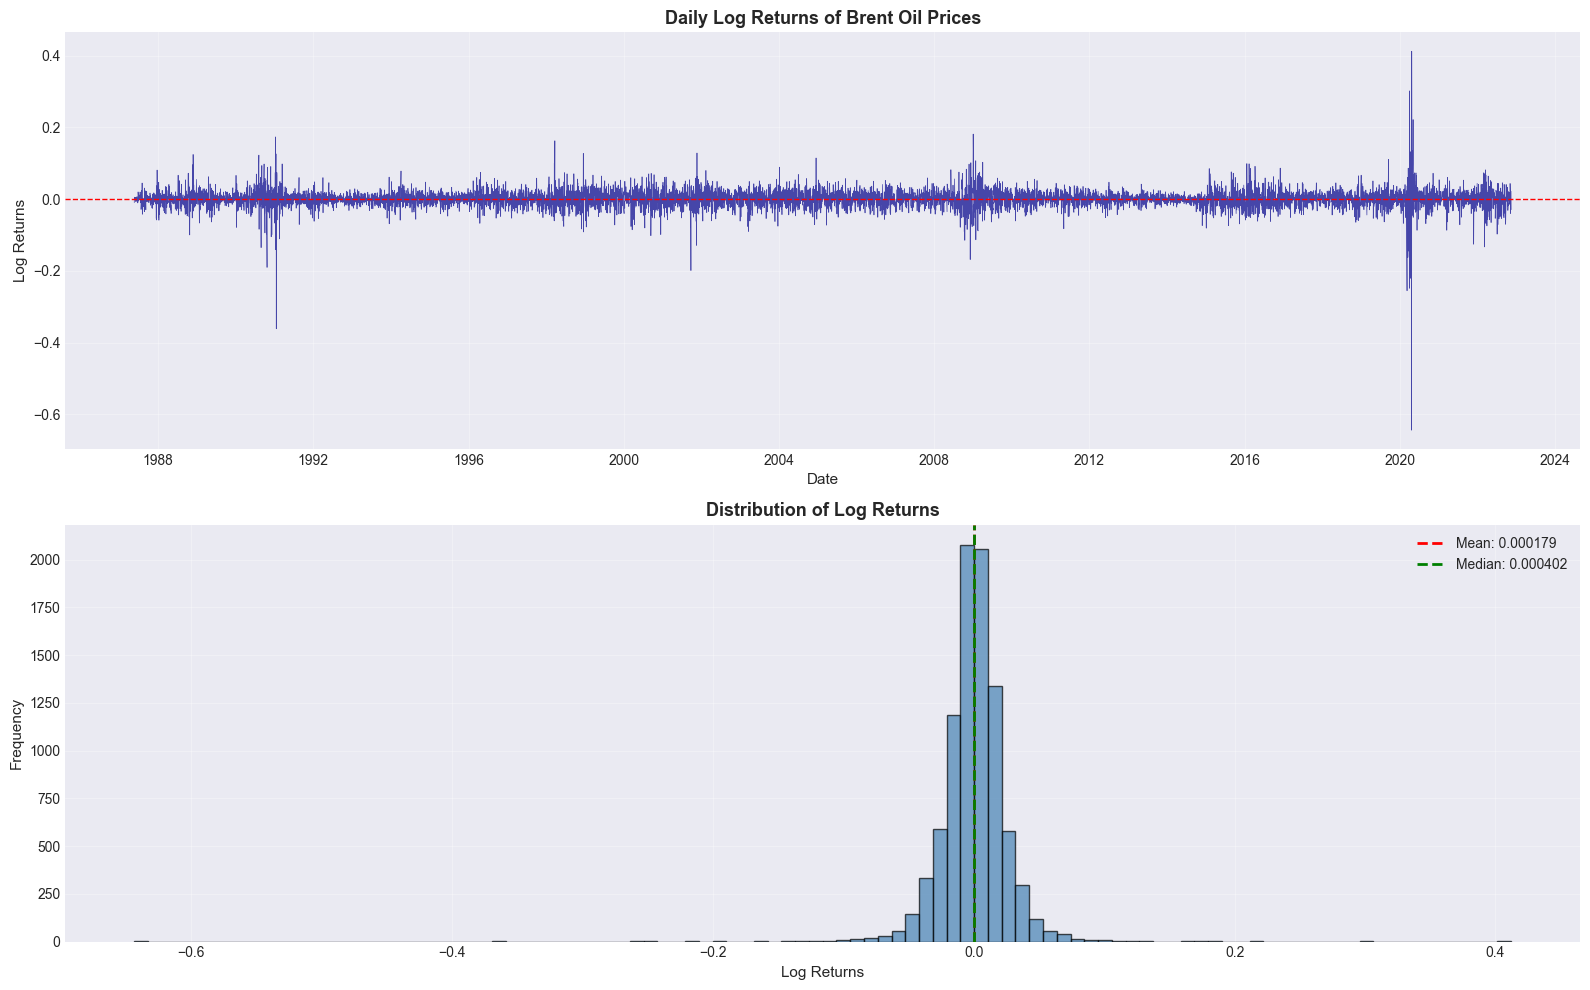

✓ Figure saved: 03_log_returns_analysis.png


In [11]:
# Visualize log returns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Log returns over time
axes[0].plot(df.index, df['Log_Returns'], linewidth=0.5, color='darkblue', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Log Returns', fontsize=11)
axes[0].set_title('Daily Log Returns of Brent Oil Prices', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Distribution of log returns
axes[1].hist(df['Log_Returns'].dropna(), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(df['Log_Returns'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Log_Returns"].mean():.6f}')
axes[1].axvline(df['Log_Returns'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["Log_Returns"].median():.6f}')
axes[1].set_xlabel('Log Returns', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Log Returns', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / '03_log_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Figure saved: 03_log_returns_analysis.png")

In [12]:
# Check for normality of log returns
from scipy.stats import shapiro, jarque_bera

returns_clean = df['Log_Returns'].dropna()

# Jarque-Bera test (better for large samples)
jb_stat, jb_pvalue = jarque_bera(returns_clean)

print("\n=== Normality Test for Log Returns ===")
print(f"Jarque-Bera Statistic: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.6f}")

if jb_pvalue > 0.05:
    print("✓ Log returns appear normally distributed (p > 0.05)")
else:
    print("✗ Log returns deviate from normality (p < 0.05)")
    print("  This suggests heavy tails or skewness - common in financial data")

# Calculate skewness and kurtosis
print(f"\nSkewness: {stats.skew(returns_clean):.4f}")
print(f"Kurtosis: {stats.kurtosis(returns_clean):.4f}")
print("\nNote: Kurtosis > 0 indicates heavy tails (more extreme values than normal distribution)")


=== Normality Test for Log Returns ===
Jarque-Bera Statistic: 1633323.0493
p-value: 0.000000
✗ Log returns deviate from normality (p < 0.05)
  This suggests heavy tails or skewness - common in financial data

Skewness: -1.7441
Kurtosis: 65.8675

Note: Kurtosis > 0 indicates heavy tails (more extreme values than normal distribution)


## 7. Volatility Analysis

Examine volatility patterns including volatility clustering.

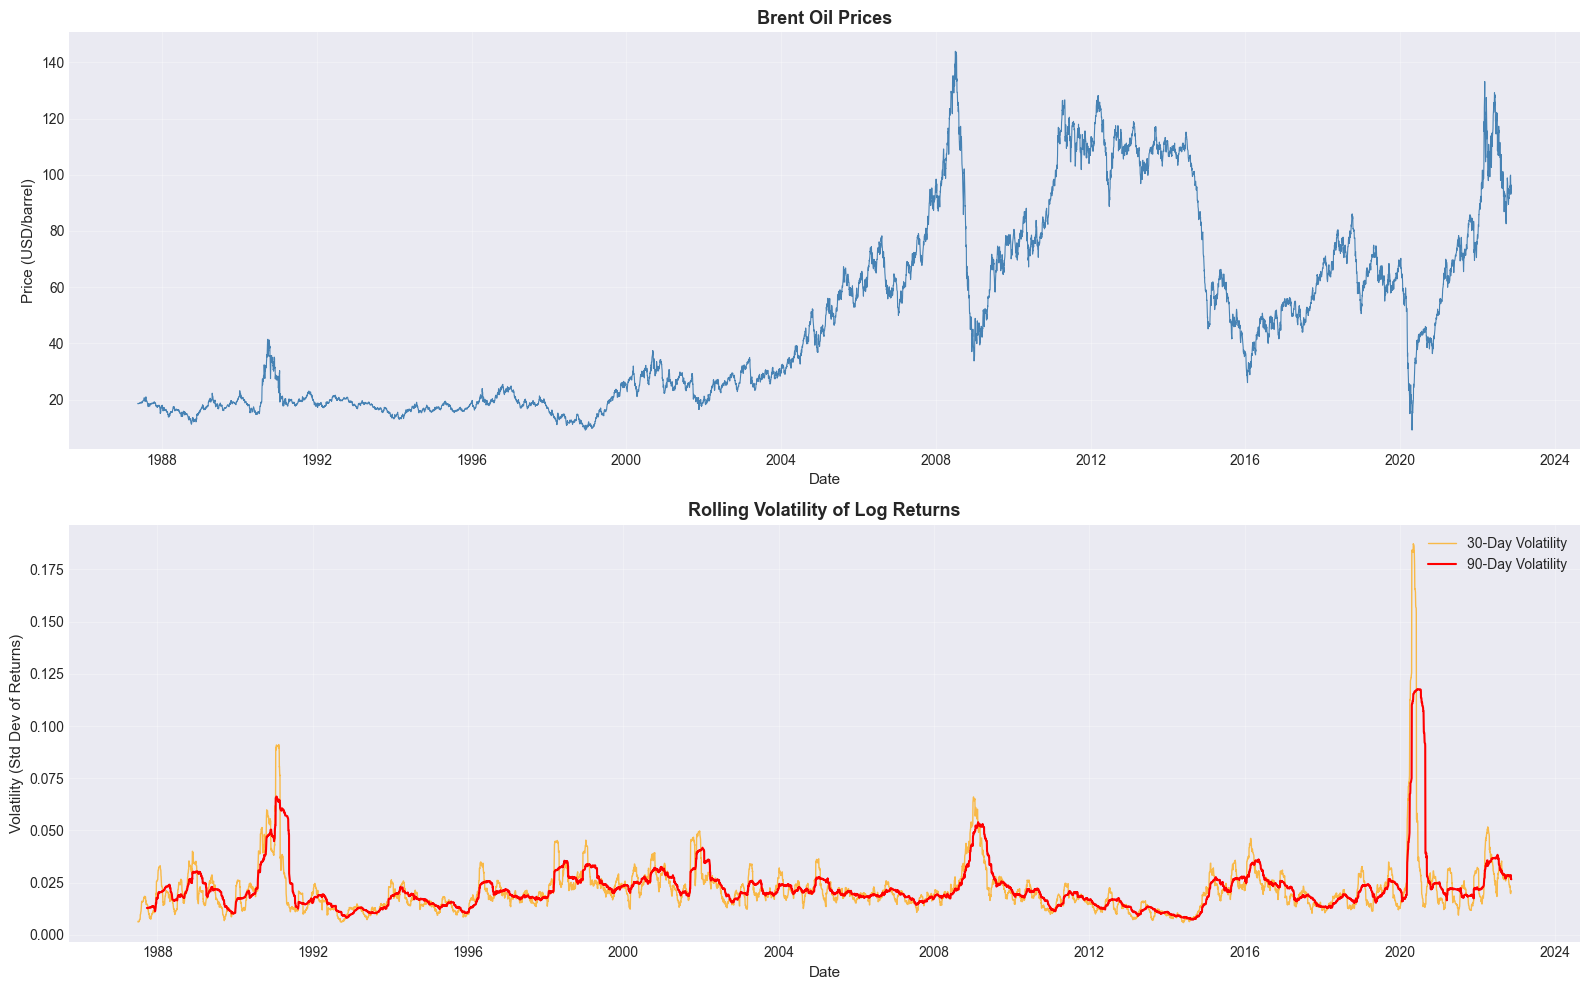


Volatility Statistics:
Average 30-day volatility: 0.021564
Maximum 30-day volatility: 0.187314
Date of max volatility: 2020-05-06 00:00:00
✓ Figure saved: 04_volatility_analysis.png


In [13]:
# Calculate rolling volatility (standard deviation of returns)
df['Volatility_30'] = df['Log_Returns'].rolling(window=30).std()
df['Volatility_90'] = df['Log_Returns'].rolling(window=90).std()

# Plot volatility over time
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Price and volatility
axes[0].plot(df.index, df['Price'], linewidth=0.8, color='steelblue')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Price (USD/barrel)', fontsize=11)
axes[0].set_title('Brent Oil Prices', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Rolling volatility
axes[1].plot(df.index, df['Volatility_30'], linewidth=1, label='30-Day Volatility', color='orange', alpha=0.7)
axes[1].plot(df.index, df['Volatility_90'], linewidth=1.5, label='90-Day Volatility', color='red')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Volatility (Std Dev of Returns)', fontsize=11)
axes[1].set_title('Rolling Volatility of Log Returns', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / '04_volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVolatility Statistics:")
print(f"Average 30-day volatility: {df['Volatility_30'].mean():.6f}")
print(f"Maximum 30-day volatility: {df['Volatility_30'].max():.6f}")
print(f"Date of max volatility: {df['Volatility_30'].idxmax()}")
print(f"✓ Figure saved: 04_volatility_analysis.png")

In [14]:
# Identify high volatility periods
volatility_threshold = df['Volatility_30'].quantile(0.90)
high_vol_periods = df[df['Volatility_30'] > volatility_threshold]

print(f"\nHigh Volatility Periods (>90th percentile = {volatility_threshold:.6f}):")
print(f"Total high volatility days: {len(high_vol_periods)}")
print(f"\nTop 10 highest volatility periods:")
print(high_vol_periods.nlargest(10, 'Volatility_30')[['Price', 'Volatility_30', 'Log_Returns']])


High Volatility Periods (>90th percentile = 0.031779):
Total high volatility days: 898

Top 10 highest volatility periods:
            Price  Volatility_30  Log_Returns
Date                                         
2020-05-06  24.20       0.187314    -0.050756
2020-05-05  25.46       0.187098     0.221574
2020-05-07  24.23       0.187052     0.001239
2020-05-11  25.53       0.186775     0.052263
2020-05-12  26.67       0.186248     0.043685
2020-05-13  27.89       0.186095     0.044729
2020-04-24  15.87       0.184364     0.052388
2020-04-23  15.06       0.183873     0.089550
2020-05-01  18.49       0.183838     0.020766
2020-04-27  15.17       0.183817    -0.045111


## 8. Autocorrelation Analysis

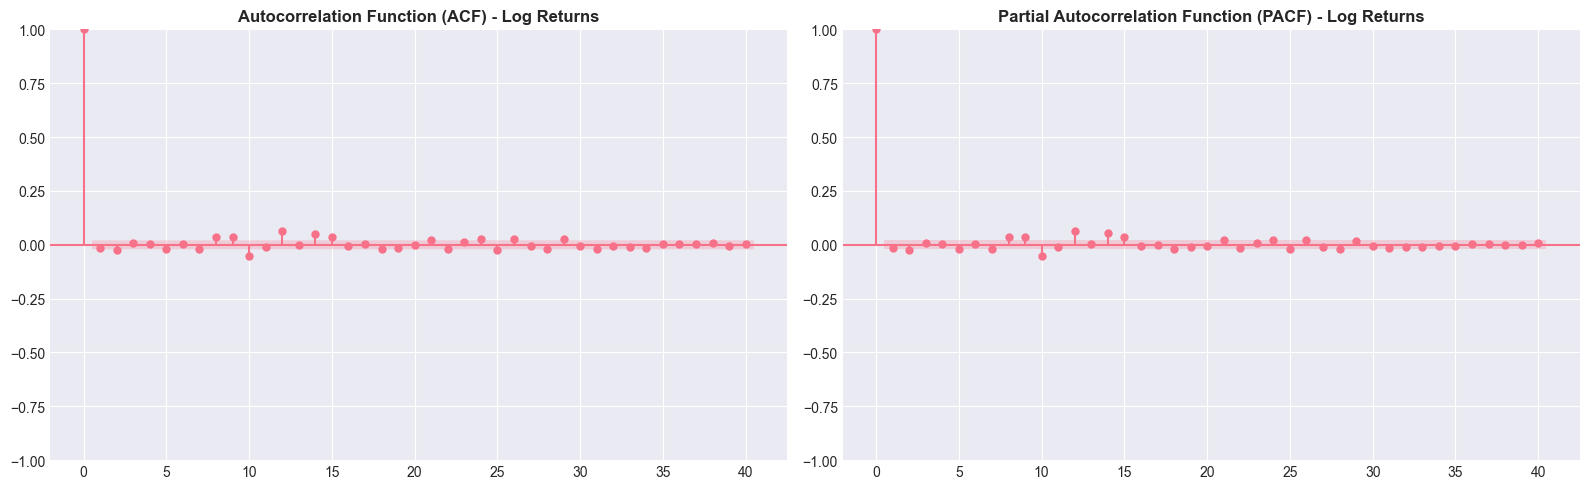


Autocorrelation Insights:
- ACF shows correlation structure in log returns
- Significant spikes indicate memory/dependence in the series
✓ Figure saved: 05_autocorrelation.png


In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for log returns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df['Log_Returns'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - Log Returns', fontsize=12, fontweight='bold')

plot_pacf(df['Log_Returns'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - Log Returns', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_DIR / '05_autocorrelation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAutocorrelation Insights:")
print("- ACF shows correlation structure in log returns")
print("- Significant spikes indicate memory/dependence in the series")
print(f"✓ Figure saved: 05_autocorrelation.png")

## 9. Focus Period: 2014-2022

Focus on recent period with major geopolitical events for change point analysis.

In [16]:
# Filter data from 2014 onwards
df_recent = df['2014-01-01':].copy()

print(f"Recent period dataset:")
print(f"Date range: {df_recent.index.min()} to {df_recent.index.max()}")
print(f"Total observations: {len(df_recent)}")
print(f"\nPrice statistics (2014-2022):")
print(df_recent['Price'].describe())

Recent period dataset:
Date range: 2014-01-02 00:00:00 to 2022-11-14 00:00:00
Total observations: 2259

Price statistics (2014-2022):
count    2259.000000
mean       66.181009
std        22.570804
min         9.120000
25%        49.255000
50%        62.580000
75%        76.685000
max       133.180000
Name: Price, dtype: float64


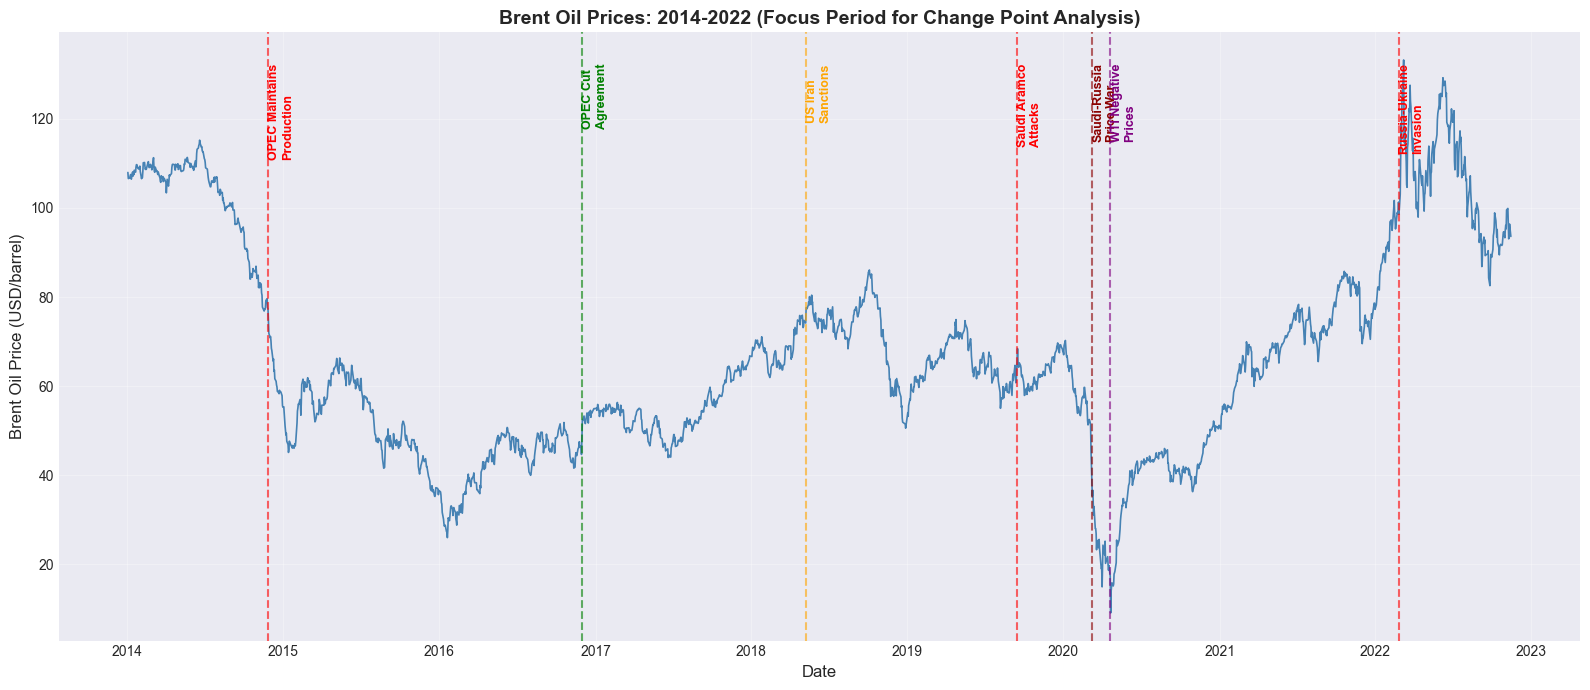

✓ Figure saved: 06_focus_period_2014_2022.png


In [17]:
# Plot recent period with annotations for major events
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(df_recent.index, df_recent['Price'], linewidth=1.2, color='steelblue')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Brent Oil Price (USD/barrel)', fontsize=12)
ax.set_title('Brent Oil Prices: 2014-2022 (Focus Period for Change Point Analysis)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Annotate major known events
events = [
    ('2014-11-27', 'OPEC Maintains\nProduction', 'red'),
    ('2016-11-30', 'OPEC Cut\nAgreement', 'green'),
    ('2018-05-08', 'US Iran\nSanctions', 'orange'),
    ('2019-09-14', 'Saudi Aramco\nAttacks', 'red'),
    ('2020-03-09', 'Saudi-Russia\nPrice War', 'darkred'),
    ('2020-04-20', 'WTI Negative\nPrices', 'purple'),
    ('2022-02-24', 'Russia-Ukraine\nInvasion', 'red'),
]

for date, label, color in events:
    ax.axvline(pd.Timestamp(date), color=color, linestyle='--', alpha=0.6, linewidth=1.5)
    ax.text(pd.Timestamp(date), ax.get_ylim()[1]*0.95, label, 
            rotation=90, verticalalignment='top', fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_DIR / '06_focus_period_2014_2022.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Figure saved: 06_focus_period_2014_2022.png")

## 10. Summary: Time Series Properties & Modeling Implications

### Key Findings:

1. **Non-Stationarity**: Raw prices are non-stationary (ADF test confirms). This requires:
   - Working with log returns for stationarity
   - Or modeling level shifts in prices directly via change point detection

2. **Volatility Clustering**: Clear evidence of periods where high volatility follows high volatility
   - Suggests modeling both mean (μ) and variance (σ) changes
   - GARCH-type effects present

3. **Heavy Tails**: Log returns show kurtosis > 0, indicating more extreme values than normal distribution
   - May need Student-t distribution instead of Normal in some models
   - Extreme events are more common than normal distribution predicts

4. **Multiple Regime Shifts**: Visual inspection shows several distinct price regimes
   - 2014-2016: Oil crash from ~$110 to ~$30
   - 2016-2019: Recovery and stabilization
   - 2020: COVID crash and recovery
   - 2022: Ukraine war spike

### Modeling Implications for Bayesian Change Point Analysis:

- **Use log returns** for better statistical properties (stationarity)
- **Model both μ and σ changes** to capture volatility regime shifts
- **Consider multiple change points** - single change point model will be too simplistic
- **Normal likelihood** is reasonable starting point, but be aware of heavy tails
- **Prior selection**: Use wide priors initially; data is informative enough

In [18]:
# Save processed data for modeling
df_recent.to_csv('../data/processed_brent_prices_2014_2022.csv')
print("Processed data saved to: ../data/processed_brent_prices_2014_2022.csv")

print("\n" + "="*70)
print("TASK 1 EDA COMPLETE")
print("="*70)
print(f"\n📊 All figures saved to: {REPORTS_DIR.absolute()}")
print("\nGenerated figures:")
print("  1. 01_brent_oil_prices_full_series.png")
print("  2. 02_moving_averages.png")
print("  3. 03_log_returns_analysis.png")
print("  4. 04_volatility_analysis.png")
print("  5. 05_autocorrelation.png")
print("  6. 06_focus_period_2014_2022.png")
print("\nNext Steps:")
print("1. Build Bayesian Change Point model in PyMC")
print("2. Associate detected change points with researched events")
print("3. Quantify impact of each major event")
print("4. Develop interactive dashboard for visualization")

Processed data saved to: ../data/processed_brent_prices_2014_2022.csv

TASK 1 EDA COMPLETE

📊 All figures saved to: c:\Users\Bekam\Desktop\acadamy 10\bayesian-oil-market-insights\notebooks\..\reports\figures

Generated figures:
  1. 01_brent_oil_prices_full_series.png
  2. 02_moving_averages.png
  3. 03_log_returns_analysis.png
  4. 04_volatility_analysis.png
  5. 05_autocorrelation.png
  6. 06_focus_period_2014_2022.png

Next Steps:
1. Build Bayesian Change Point model in PyMC
2. Associate detected change points with researched events
3. Quantify impact of each major event
4. Develop interactive dashboard for visualization
